In [1]:
# This code works in Python 3.10.6
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
import torch_geometric.transforms as T
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
from torch_geometric.datasets.dblp import DBLP
import os
import os.path as osp

### DBLP

In [3]:
dataset = DBLP(root='./dblp_data', transform=T.Constant(node_types='conference'))
data = dataset[0]
data

HeteroData(
  author={
    x=[4057, 334],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057]
  },
  paper={ x=[14328, 4231] },
  term={ x=[7723, 50] },
  conference={
    num_nodes=20,
    x=[20, 1]
  },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, author)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)

In [4]:
author = data['author'].x.tolist()
author_df = pd.DataFrame(author)
author_df['class'] = data['author'].y.tolist()

### Bag-of-Words features of Author node

In [5]:
author_class0 = author_df[author_df['class'] == 0].drop(['class'], axis = 1)
author_class0.head()

,0,1,2,3,4,5,6,7,8,9,...,324,325,326,327,328,329,330,331,332,333
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [6]:
author_class1 = author_df[author_df['class'] == 1].drop(['class'], axis = 1)
author_class1.head()

,0,1,2,3,4,5,6,7,8,9,...,324,325,326,327,328,329,330,331,332,333
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
author_class2 = author_df[author_df['class'] == 2].drop(['class'], axis = 1)
author_class2.head()

,0,1,2,3,4,5,6,7,8,9,...,324,325,326,327,328,329,330,331,332,333
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [8]:
author_class3 = author_df[author_df['class'] == 3].drop(['class'], axis = 1)
author_class3.head()

,0,1,2,3,4,5,6,7,8,9,...,324,325,326,327,328,329,330,331,332,333
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
21,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
def sample_features(model,node_type, n_samples):

    smpls = model.sample(n_samples)
    print("no. of class {} node samples - {}".format(node_type, n_samples))
    return smpls[0]

In [10]:
def fit_sample_gm(df_class, node_type, n_samples):
    #fit
    model = GaussianMixture(n_components=1, covariance_type='full', random_state = 0)
    model.fit(df_class)
    #print("Mean for nodetype", node_type,model.means_)
    #sample
    smpls = sample_features(model, node_type, n_samples)
    new_features_dict[node_type] = smpls

In [11]:
def feature_selection(df):
    col_sum = df.sum(axis=0)
    sorted_colsum = sorted(col_sum, reverse=True)

    index_list = []
    for i in sorted_colsum[:1]:
        index_list.append(list(col_sum).index(i))
    imp_feat = df[index_list].reset_index(drop=True)
    return imp_feat

In [12]:
def convert_to_dicrete(df):
    return df.applymap(lambda x: 0.0 if x<0.5 else 1.0)

In [13]:
plt.rcParams.update({'axes.ymargin': 0.2})

In [14]:
def compare_plot_real_syn(df):
    df_new = df.apply(pd.value_counts).T
    print(df_new)
    ax=df_new.plot.bar(width=0.4,figsize=(7,7))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
    for i in ax.containers:
        ax.bar_label(i,fontsize=20)
    
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize="20", loc ="lower center")
    plt.ylabel('no. of samples',fontsize=20)   
    plt.tight_layout()
    plt.show()
    plt.clf() 

In [15]:
def cosine_sim(original,sampled):
    return cosine_similarity(np.array(original), np.array(sampled))

### Fit Gaussian Mixture Models to 4 Author node classes

In [16]:
new_features_dict = {}

In [17]:
fit_sample_gm(author_class0, 'author0', author_class0.shape[0])
fit_sample_gm(author_class1, 'author1', author_class1.shape[0])
fit_sample_gm(author_class2, 'author2', author_class2.shape[0])
fit_sample_gm(author_class3, 'author3', author_class3.shape[0])

no. of class author0 node samples - 1197
no. of class author1 node samples - 745
no. of class author2 node samples - 1109
no. of class author3 node samples - 1006


### Continuous features sampled using Gaussian Mixure Models

In [18]:
sampled0  = pd.DataFrame(new_features_dict['author0'])
sampled0.head()

,0,1,2,3,4,5,6,7,8,9,...,324,325,326,327,328,329,330,331,332,333
0,-0.532021,-0.114518,0.039727,-0.172586,-0.143124,-0.060956,0.015907,-0.009368,-0.039130,0.062917,...,0.099614,0.052082,0.049812,-0.070774,-0.154396,-0.031203,0.008766,0.070347,-0.088451,0.078143
1,0.092519,0.407700,-0.005014,-0.100648,0.267799,-0.241563,0.045965,0.077764,0.008118,0.391670,...,0.315016,0.484640,0.974562,0.348290,0.133252,0.100689,0.171542,-0.016405,-0.023549,0.585849
2,0.032044,0.482432,0.027092,0.055165,0.262292,-0.007668,-0.011093,-0.069321,0.135996,0.033550,...,-0.103522,0.071997,-0.005881,0.209913,0.154399,0.191658,0.107776,0.037447,-0.178434,-0.314921
3,-0.188429,0.193549,0.056708,0.076883,-0.138256,0.217960,0.081473,-0.011333,0.118201,0.125058,...,0.041225,0.331136,-0.232816,-0.025912,0.029545,0.286247,0.187362,0.042223,0.255639,0.110490
4,0.348712,0.211250,0.060869,0.097975,0.375198,0.316392,-0.000135,-0.005339,0.015358,-0.113830,...,0.336396,0.151874,0.281187,0.108594,0.224729,0.109000,-0.197732,-0.041921,0.171626,0.467666


In [19]:
sampled1  = pd.DataFrame(new_features_dict['author1'])
sampled1.head()

,0,1,2,3,4,5,6,7,8,9,...,324,325,326,327,328,329,330,331,332,333
0,-0.077435,0.082057,-0.121383,-0.041293,0.214821,0.076300,0.127666,0.153478,0.054322,0.321459,...,-0.155539,0.080558,-0.110835,-0.122441,-0.009048,-0.183707,-0.095166,0.220730,-0.132238,-0.077274
1,-0.164771,0.148378,0.002699,0.000043,-0.017535,0.383876,0.065270,-0.188466,0.205074,0.593453,...,0.356740,0.108951,0.131614,0.524586,0.044294,0.533391,0.398871,0.104754,0.063656,0.186809
2,0.185981,0.276852,-0.004858,-0.073044,-0.034488,0.369003,0.133104,-0.097940,0.107236,-0.173667,...,0.200170,0.052883,-0.090678,0.435313,0.355530,-0.082590,0.288635,-0.163279,0.039227,0.256935
3,0.101772,0.095751,0.230624,-0.157403,0.028799,0.178913,-0.145457,-0.008257,-0.251699,0.286762,...,0.122597,0.004831,-0.034522,-0.042283,0.149033,-0.292826,0.244343,0.026539,-0.012096,0.021428
4,0.037384,0.253126,-0.224584,0.072162,-0.034409,0.288421,-0.001396,0.035883,0.310436,0.191529,...,0.148910,0.041474,-0.000920,0.129186,-0.101656,0.352315,-0.062130,0.107375,0.198902,-0.194560


In [20]:
sampled2  = pd.DataFrame(new_features_dict['author2'])
sampled2.head()

,0,1,2,3,4,5,6,7,8,9,...,324,325,326,327,328,329,330,331,332,333
0,0.088102,0.081260,0.159967,-0.250958,-0.017439,0.221970,-0.217471,-0.021608,0.042670,0.267404,...,-0.376162,-0.018777,-0.060400,-0.241778,-0.014879,-0.248756,0.176880,-0.005660,0.134828,-0.002910
1,0.358004,0.024926,0.044721,0.023954,0.228065,0.353241,0.272586,0.159438,0.097464,0.113705,...,0.137949,-0.097725,0.016616,-0.058574,0.048264,0.255139,0.122271,-0.003626,0.252395,-0.038014
2,0.006478,0.141070,-0.104173,0.098083,0.071000,0.267231,0.098931,-0.079228,-0.070786,0.304853,...,-0.129048,0.145938,0.058712,0.215193,-0.021477,-0.276515,0.029288,0.051905,0.110030,0.029370
3,0.115758,0.216884,0.105839,-0.040352,0.066464,0.032255,0.030454,-0.062107,-0.054313,0.399222,...,0.326867,-0.161651,0.014198,0.104073,-0.012976,-0.097021,-0.101630,0.213357,0.107449,0.003346
4,0.303535,0.012479,0.036154,0.532712,0.121618,0.034327,0.408023,0.042668,0.205501,0.097441,...,-0.136809,0.047107,0.122983,0.124007,0.041465,0.135132,0.206212,-0.140176,0.230329,-0.025534


In [21]:
sampled3  = pd.DataFrame(new_features_dict['author3'])
sampled3.head()

,0,1,2,3,4,5,6,7,8,9,...,324,325,326,327,328,329,330,331,332,333
0,-0.347290,-0.107141,0.051867,-0.038824,0.012151,0.396174,0.010068,0.035940,-0.045169,0.198115,...,-0.473399,-0.055315,-0.046552,-0.080842,0.083669,-0.991198,-0.103029,-0.110465,-0.207939,-0.093671
1,0.203031,0.308078,-0.002546,0.063741,0.069453,0.174271,0.125020,0.016250,0.006399,-0.145443,...,0.465827,0.053950,-0.014289,0.036123,0.318863,1.194100,0.084357,0.148110,-0.043153,-0.018653
2,0.046672,-0.292591,0.122958,-0.031244,-0.022057,0.271392,-0.057939,0.021622,0.080188,-0.128772,...,0.272044,0.064674,-0.005936,0.122513,-0.181799,0.928868,0.053707,-0.172966,-0.062427,-0.172658
3,0.013175,0.142323,0.051927,-0.034070,0.003418,-0.000135,0.014181,0.012276,-0.064827,0.051297,...,0.088615,0.114526,0.035632,-0.010332,0.027932,0.389178,-0.053280,-0.190268,-0.020022,0.057846
4,-0.006974,-0.011374,0.116974,-0.068180,-0.164175,0.199676,0.016667,0.022047,0.046031,0.344867,...,0.057203,0.061772,-0.023717,0.161079,-0.148232,0.152062,0.057256,0.197136,-0.112787,0.083736


### Sampled continuous features are converted to discrete using a threshold

In [22]:
authorclass0_sampled = convert_to_dicrete(pd.DataFrame(new_features_dict['author0']))
authorclass0_sampled.head()

,0,1,2,3,4,5,6,7,8,9,...,324,325,326,327,328,329,330,331,332,333
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
authorclass1_sampled = convert_to_dicrete(pd.DataFrame(new_features_dict['author1']))
authorclass1_sampled.head()

,0,1,2,3,4,5,6,7,8,9,...,324,325,326,327,328,329,330,331,332,333
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
authorclass2_sampled = convert_to_dicrete(pd.DataFrame(new_features_dict['author2']))
authorclass2_sampled.head()

,0,1,2,3,4,5,6,7,8,9,...,324,325,326,327,328,329,330,331,332,333
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
authorclass3_sampled = convert_to_dicrete(pd.DataFrame(new_features_dict['author3']))
authorclass3_sampled.head()

,0,1,2,3,4,5,6,7,8,9,...,324,325,326,327,328,329,330,331,332,333
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Comparison of real and synthetic distributions for the most important feature

Author class 0

In [26]:
real_imp_feat0 =feature_selection(pd.DataFrame(author_class0))
real_imp_feat0.shape[0]

1197

In [27]:
syn_imp_feat0=feature_selection(authorclass0_sampled)
syn_imp_feat0.shape[0]

1197

           0.0  1.0
Real       645  552
Synthetic  653  544


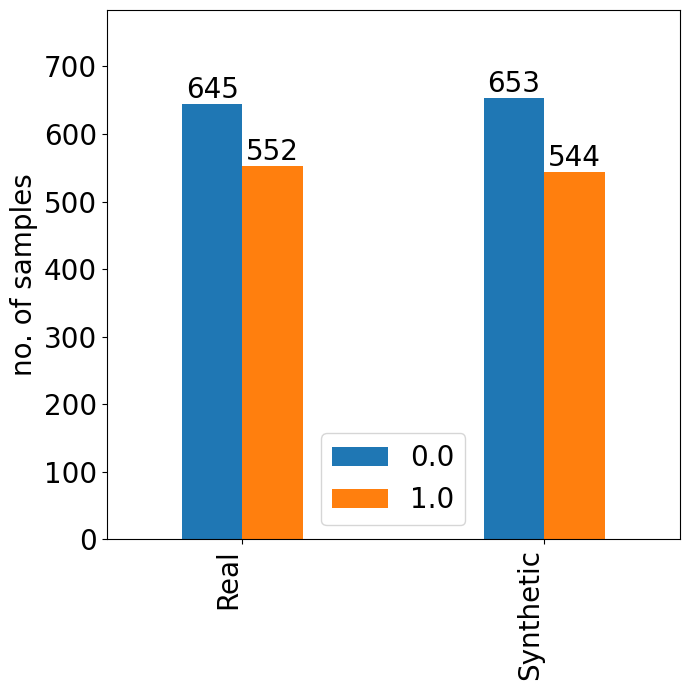

<Figure size 640x480 with 0 Axes>

In [28]:
df0_compare_impfeat = pd.DataFrame()
df0_compare_impfeat['Real'] = real_imp_feat0[:syn_imp_feat0.shape[0]]
df0_compare_impfeat['Synthetic'] = syn_imp_feat0
compare_plot_real_syn(df0_compare_impfeat)

Author class 1

In [29]:
real_imp_feat1 =feature_selection(pd.DataFrame(author_class1))
real_imp_feat1.shape[0]

745

In [30]:
syn_imp_feat1=feature_selection(authorclass1_sampled)
syn_imp_feat1.shape[0]

745

           1.0  0.0
Real       399  346
Synthetic  380  365


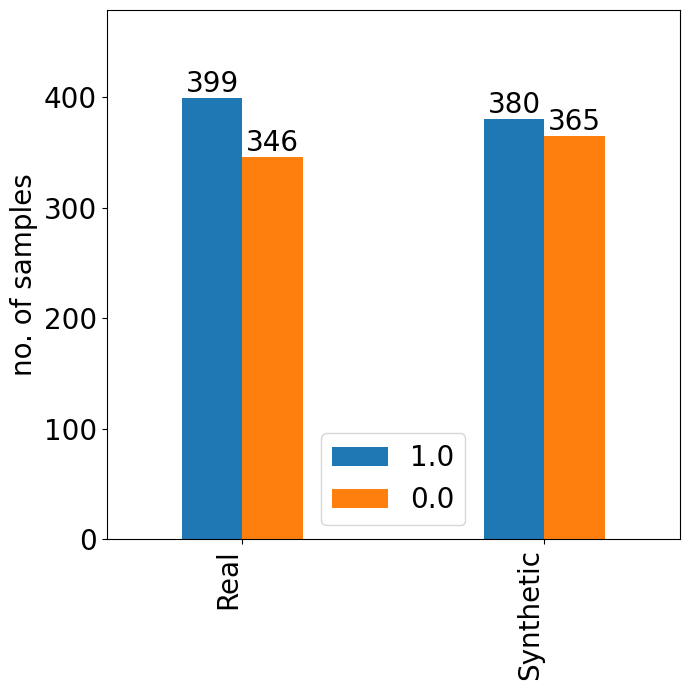

<Figure size 640x480 with 0 Axes>

In [31]:
df1_compare_impfeat = pd.DataFrame()
df1_compare_impfeat['Real'] = real_imp_feat1[:syn_imp_feat1.shape[0]]
df1_compare_impfeat['Synthetic'] = syn_imp_feat1
compare_plot_real_syn(df1_compare_impfeat)

In [32]:
df1_compare_impfeat

,Real,Synthetic
0,0.0,0.0
1,0.0,1.0
2,1.0,1.0
3,1.0,1.0
4,0.0,0.0
...,...,...
740,0.0,1.0
741,0.0,1.0
742,1.0,0.0
743,1.0,0.0


In [33]:
from collections import Counter
Counter(list(df1_compare_impfeat['Real']))

Counter({1.0: 399, 0.0: 346})

Author class 2

In [34]:
real_imp_feat2 = feature_selection(pd.DataFrame(author_class2))
real_imp_feat2.shape[0]

1109

In [35]:
syn_imp_feat2 = feature_selection(authorclass2_sampled)
syn_imp_feat2.shape[0]

1109

           0.0  1.0
Real       808  301
Synthetic  764  345


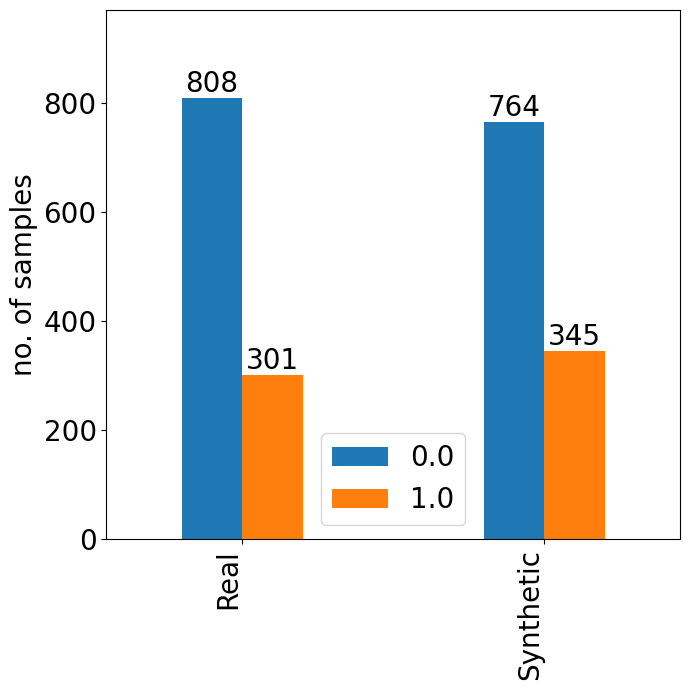

<Figure size 640x480 with 0 Axes>

In [36]:
df2_compare_impfeat = pd.DataFrame()
df2_compare_impfeat['Real'] = real_imp_feat2[:syn_imp_feat2.shape[0]]
df2_compare_impfeat['Synthetic'] = syn_imp_feat2
compare_plot_real_syn(df2_compare_impfeat)

Author class 3

In [37]:
real_imp_feat3 = feature_selection(pd.DataFrame(author_class3))
real_imp_feat3.shape[0]

1006

In [38]:
syn_imp_feat3 = feature_selection(authorclass3_sampled)
syn_imp_feat3.shape[0]

1006

           0.0  1.0
Real       567  439
Synthetic  530  476


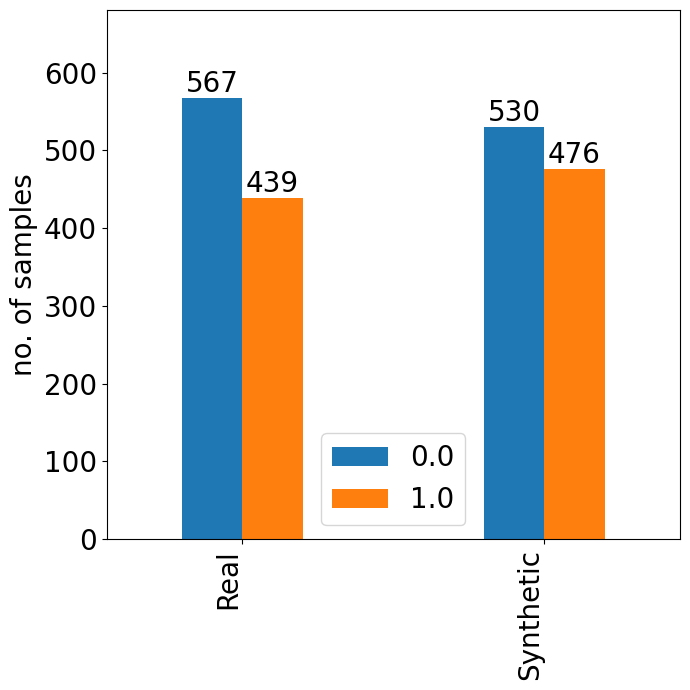

<Figure size 640x480 with 0 Axes>

In [39]:
df3_compare_impfeat = pd.DataFrame()
df3_compare_impfeat['Real'] = real_imp_feat3[:syn_imp_feat3.shape[0]]
df3_compare_impfeat['Synthetic'] = syn_imp_feat3
compare_plot_real_syn(df3_compare_impfeat)

### Pairwise cosine similarity of all features for real and synthetic distributions

Author class 0

In [40]:
cosine_sim(author_class0,authorclass0_sampled)

array([[0.        , 0.10910895, 0.10425721, ..., 0.18898224, 0.        ,
        0.        ],
       [0.        , 0.21821789, 0.34752402, ..., 0.12598816, 0.25      ,
        0.        ],
       [0.        , 0.2057378 , 0.14744196, ..., 0.08908708, 0.11785113,
        0.09622504],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.10910895, 0.20851441, ..., 0.        , 0.125     ,
        0.        ]])

In [41]:
sns.set(font_scale=1.4)

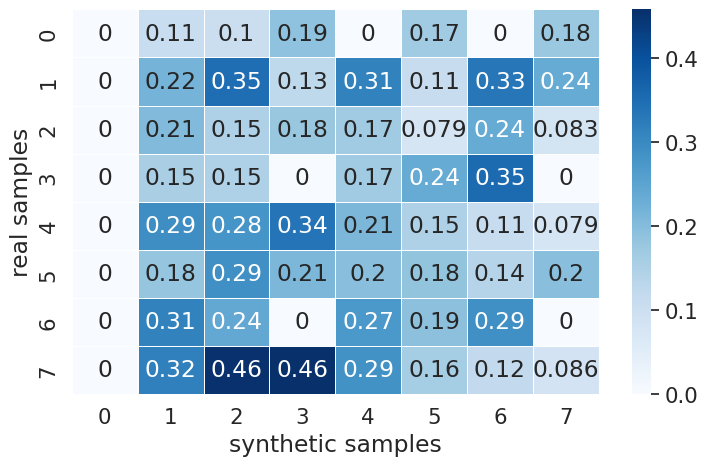

In [42]:
fig, ax = plt.subplots(figsize=(8.5,5)) 
sns.heatmap(cosine_sim(author_class0.iloc[:8],authorclass0_sampled[:8]), 
            xticklabels = 1, yticklabels = 1, annot=True, cmap='Blues', linewidth=.5)
plt.xlabel("synthetic samples") 
plt.ylabel("real samples") 
plt.show()

Author class 1

In [43]:
cosine_sim(author_class1,authorclass1_sampled)

array([[0.        , 0.        , 0.12038585, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.10721125, 0.12038585, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.40852974, 0.33362306, ..., 0.07559289, 0.26832816,
        0.08164966],
       ...,
       [0.        , 0.16609096, 0.09325048, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.09284767, 0.10425721, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.07018624, 0.15762208, ..., 0.14285714, 0.        ,
        0.15430335]])

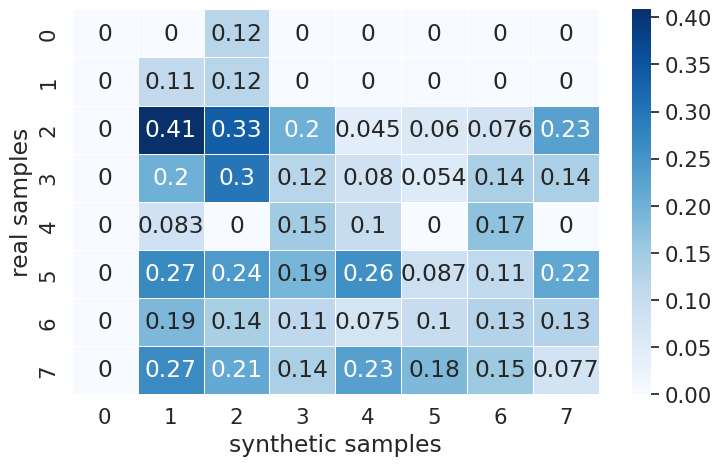

In [44]:
fig, ax = plt.subplots(figsize=(8.5,5))
sns.heatmap(cosine_sim(author_class1.iloc[:8],authorclass1_sampled[:8]), 
            xticklabels = 1, yticklabels = 1, annot=True, cmap='Blues', linewidth=.5)
plt.xlabel("synthetic samples") 
plt.ylabel("real samples") 
plt.show()

Author class 2

In [45]:
cosine_sim(author_class2,authorclass2_sampled)

array([[0.        , 0.        , 0.10482848, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.21320072, 0.11826248, ..., 0.        , 0.        ,
        0.        ],
       [0.08908708, 0.22047928, 0.20965697, ..., 0.        , 0.12598816,
        0.12598816],
       ...,
       [0.        , 0.125     , 0.        , ..., 0.        , 0.        ,
        0.5       ],
       [0.        , 0.08838835, 0.19611614, ..., 0.        , 0.1767767 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

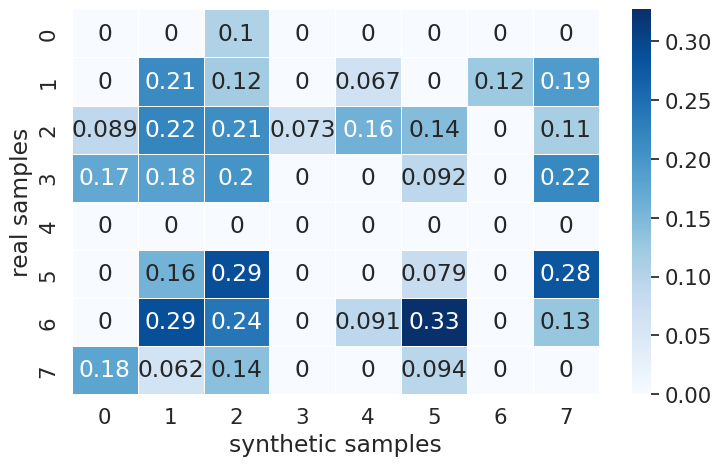

In [46]:
fig, ax = plt.subplots(figsize=(8.5,5))
sns.heatmap(cosine_sim(author_class2.iloc[:8],authorclass2_sampled[:8]), 
            xticklabels = 1, yticklabels = 1, annot=True, cmap='Blues', linewidth=.5)
plt.xlabel("synthetic samples") 
plt.ylabel("real samples") 
plt.show()

Author class 3

In [47]:
cosine_sim(author_class3,authorclass3_sampled)

array([[0.        , 0.18898224, 0.25197632, ..., 0.21821789, 0.        ,
        0.        ],
       [0.        , 0.28347335, 0.25197632, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.1767767 , 0.23570226, ..., 0.10206207, 0.125     ,
        0.25      ],
       ...,
       [0.        , 0.14433757, 0.19245009, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

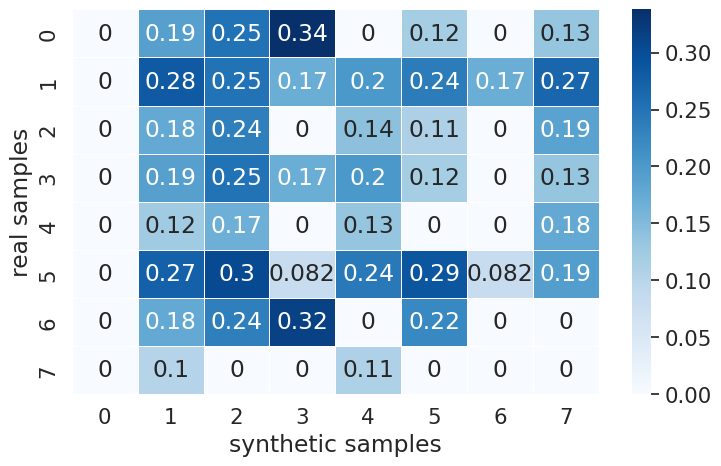

In [48]:
fig, ax = plt.subplots(figsize=(8.5,5))
sns.heatmap(cosine_sim(author_class3.iloc[:8],authorclass3_sampled[:8]), 
            xticklabels = 1, yticklabels = 1, annot=True, cmap='Blues', linewidth=.5)
plt.xlabel("synthetic samples") 
plt.ylabel("real samples") 
plt.show()